In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.9":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.9":
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.21.1", 'matplotlib': "3.4.2",'sklearn': "0.24.2", 
                'pandas': "1.3.1",'xgboost': "1.3.3", 'shap': "0.39.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.9.7 | packaged by conda-forge | (default, Sep  2 2021, 17:58:46) 
[Clang 11.1.0 ]

[ OK ] numpy version 1.21.1 is installed.
[ OK ] matplotlib version 3.4.2 is installed.
[ OK ] sklearn version 0.24.2 is installed.
[ OK ] pandas version 1.3.1 is installed.
[ OK ] xgboost version 1.3.3 is installed.
[ OK ] shap version 0.39.0 is installed.


In [2]:
fname = '../figures/'

## Imports

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as plt
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedShuffleSplit, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Load the Data

In [4]:
df = pd.read_csv("../data/fifa19_dataset.csv", index_col = 0)
df = df.iloc[: , 1:]
df.head()

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## Gather info on the Dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18207 entries, 0 to 18206
Data columns (total 87 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      18207 non-null  object 
 1   Age                       18207 non-null  int64  
 2   Photo                     18207 non-null  object 
 3   Nationality               18207 non-null  object 
 4   Flag                      18207 non-null  object 
 5   Overall                   18207 non-null  int64  
 6   Potential                 18207 non-null  int64  
 7   Club                      17966 non-null  object 
 8   Club Logo                 18207 non-null  object 
 9   Value                     18207 non-null  object 
 10  Wage                      18207 non-null  object 
 11  Special                   18207 non-null  int64  
 12  Preferred Foot            18159 non-null  object 
 13  International Reputation  18159 non-null  float64
 14  Weak F

## Determine the number of rows and columns

In [6]:
rows = df.shape[0]
columns = df.shape[1]

print("Number of rows: ", rows)
print("Number of columns: ", columns)

Number of rows:  18207
Number of columns:  87


## Determine the data types for each attribute

In [7]:
dtype_Dict = df.dtypes.to_dict()

for column_name, d_type in dtype_Dict.items(): 
    print(column_name,": ", d_type)

Name :  object
Age :  int64
Photo :  object
Nationality :  object
Flag :  object
Overall :  int64
Potential :  int64
Club :  object
Club Logo :  object
Value :  object
Wage :  object
Special :  int64
Preferred Foot :  object
International Reputation :  float64
Weak Foot :  float64
Skill Moves :  float64
Work Rate :  object
Body Type :  object
Real Face :  object
Position :  object
Jersey Number :  float64
Joined :  object
Loaned From :  object
Contract Valid Until :  object
Height :  object
Weight :  object
LS :  object
ST :  object
RS :  object
LW :  object
LF :  object
CF :  object
RF :  object
RW :  object
LAM :  object
CAM :  object
RAM :  object
LM :  object
LCM :  object
CM :  object
RCM :  object
RM :  object
LWB :  object
LDM :  object
CDM :  object
RDM :  object
RWB :  object
LB :  object
LCB :  object
CB :  object
RCB :  object
RB :  object
Crossing :  float64
Finishing :  float64
HeadingAccuracy :  float64
ShortPassing :  float64
Volleys :  float64
Dribbling :  float64
Curve

## Determine the number of numerical and categorical features

In [8]:
numerical_values = ["int64", "Float64"]
categorical_values = ["object"]
count_numerical_values = len(df.select_dtypes(include = numerical_values).columns)
count_categorical_values = len(df.select_dtypes(include = categorical_values).columns)

print("Number of Numerical Features: ", count_numerical_values)
print("Number of Categorical Features: ", count_categorical_values)

Number of Numerical Features:  42
Number of Categorical Features:  45


## Describe the Dataframe

In [9]:
df.describe()

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,49.734181,45.550911,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,18.364524,19.525820,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,5.000000,2.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,38.000000,30.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,54.000000,49.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,64.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,93.000000,95.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


## Describe the Target Variable

In [10]:
df["Position"].describe()

count     18147
unique       27
top          ST
freq       2152
Name: Position, dtype: object

## Determine if there are empty values

In [11]:
df.isna().any().any()

True

## How many empty values are there

In [12]:
df.isna().sum().sum()

76984

## Determine the sum of missing values for each column 

In [13]:
df.isnull().sum()

Name                 0
Age                  0
Photo                0
Nationality          0
Flag                 0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 87, dtype: int64

## Percentage of empty values for each attribute

In [14]:
df.isna().sum()/(len(df))*100

Name              0.000000
Age               0.000000
Photo             0.000000
Nationality       0.000000
Flag              0.000000
                    ...   
GKHandling        0.263635
GKKicking         0.263635
GKPositioning     0.263635
GKReflexes        0.263635
Release Clause    8.590103
Length: 87, dtype: float64

## Display columns with empty values

In [15]:
df.loc[:, df.isnull().any()].columns

Index(['Club', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause'],
      dtype='object')

In [16]:
df["Position"].values

array(['RF', 'ST', 'LW', ..., 'ST', 'RW', 'CM'], dtype=object)

## Fill in the missing values with NaN

In [17]:
df.fillna(np.nan)

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,https://cdn.sofifa.org/flags/14.png,47,65,Crewe Alexandra,https://cdn.sofifa.org/teams/2/light/121.png,€60K,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,https://cdn.sofifa.org/flags/46.png,47,63,Trelleborgs FF,https://cdn.sofifa.org/teams/2/light/703.png,€60K,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,B. Worman,16,https://cdn.sofifa.org/players/4/19/241638.png,England,https://cdn.sofifa.org/flags/14.png,47,67,Cambridge United,https://cdn.sofifa.org/teams/2/light/1944.png,€60K,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,D. Walker-Rice,17,https://cdn.sofifa.org/players/4/19/246268.png,England,https://cdn.sofifa.org/flags/14.png,47,66,Tranmere Rovers,https://cdn.sofifa.org/teams/2/light/15048.png,€60K,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


<AxesSubplot:>

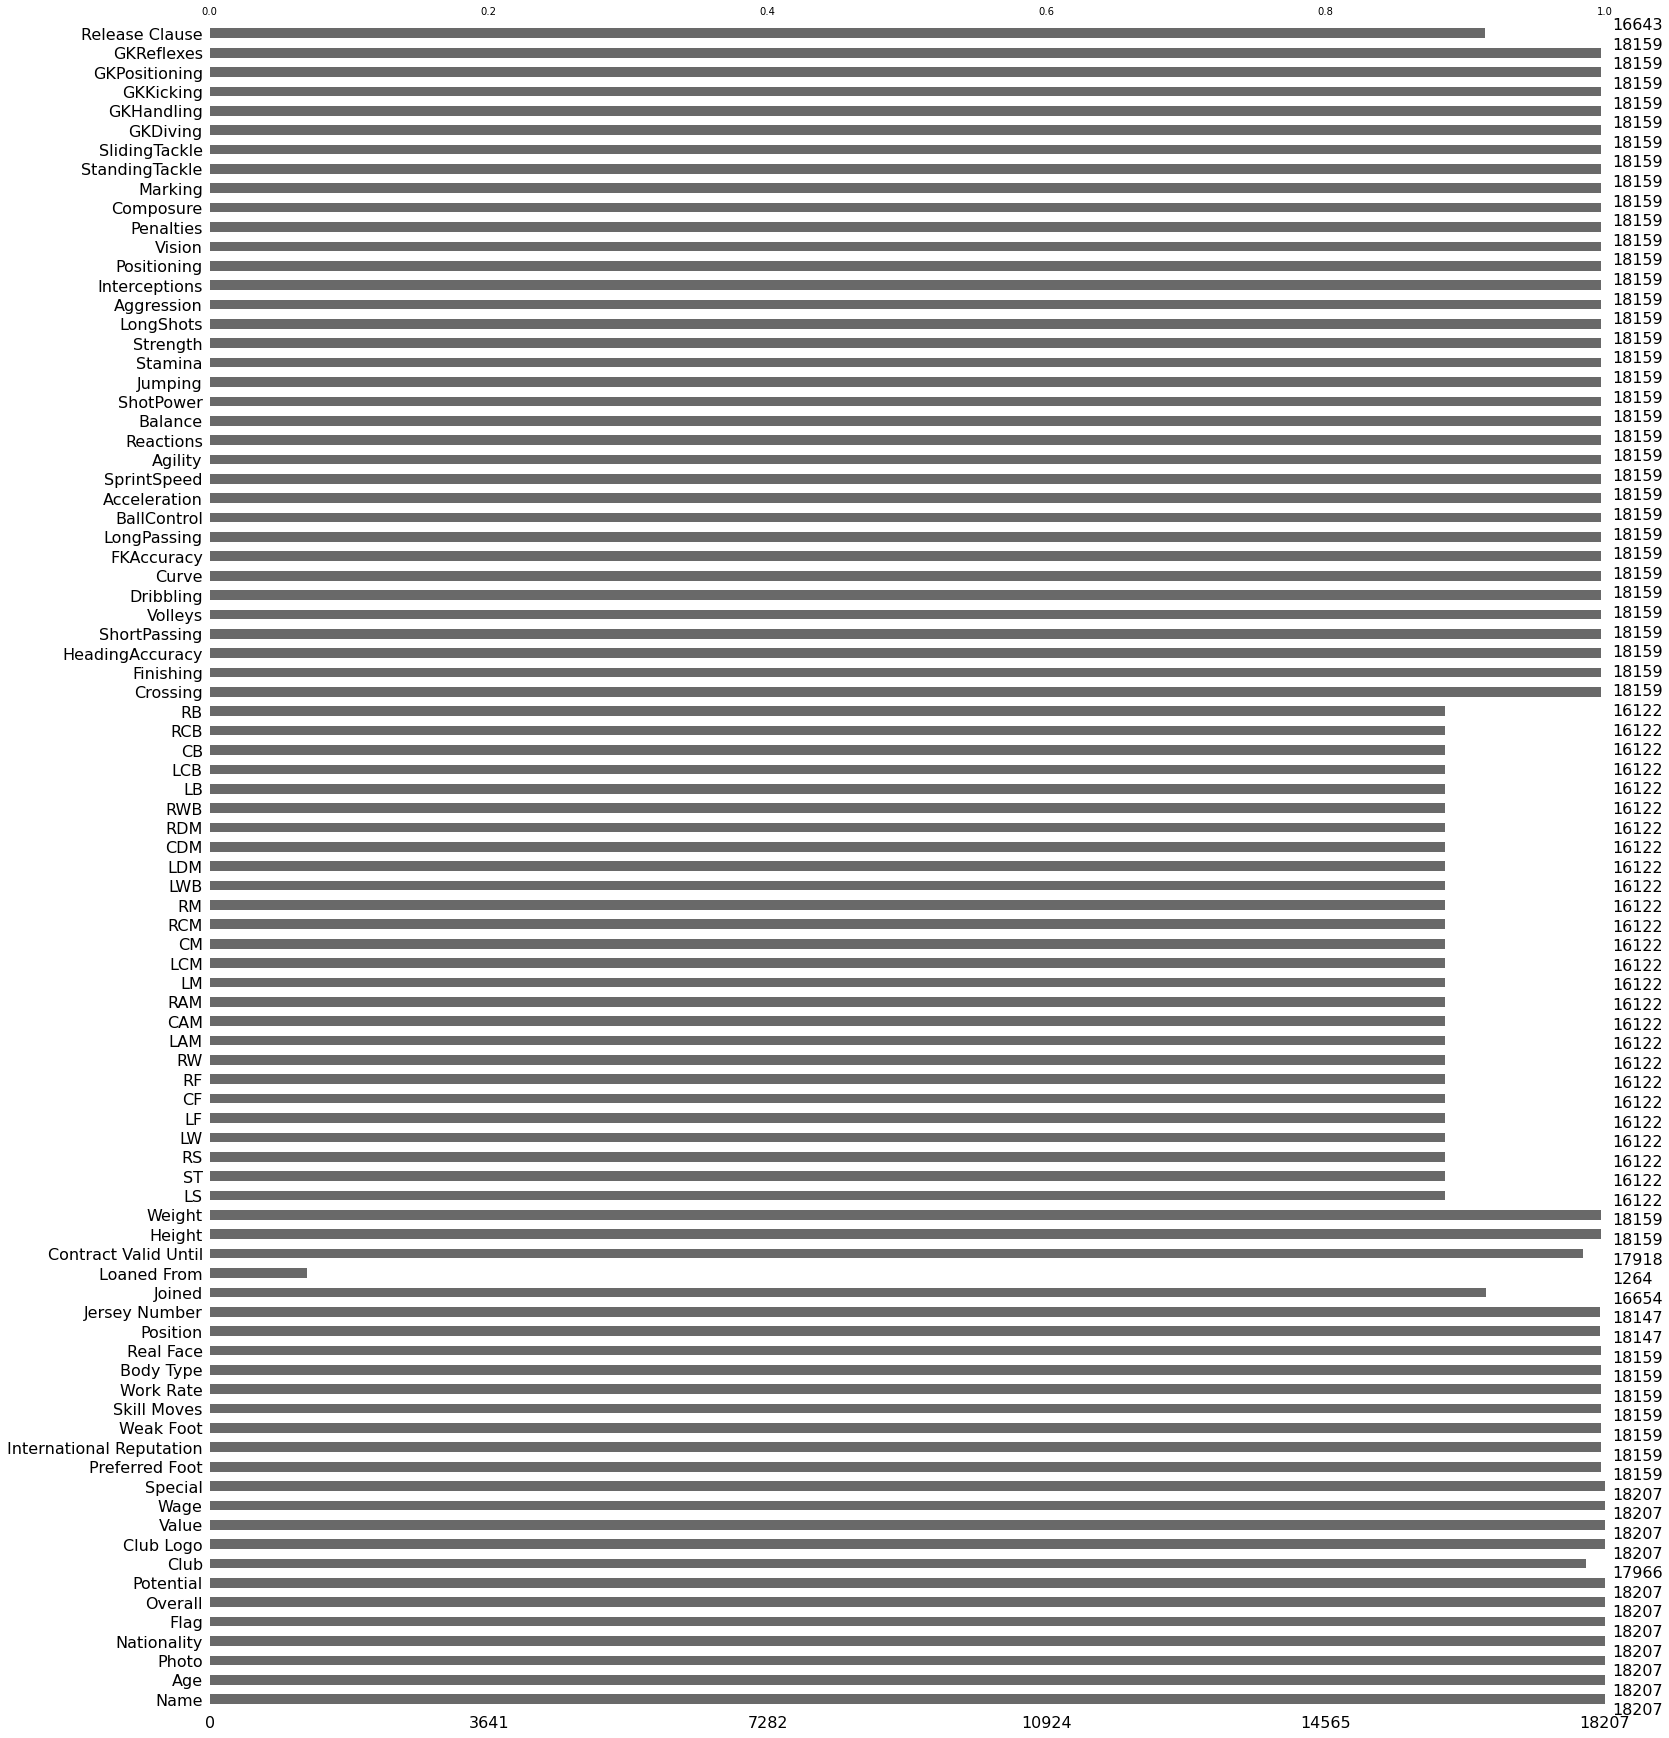

In [20]:
msno.bar(df)

<AxesSubplot:>

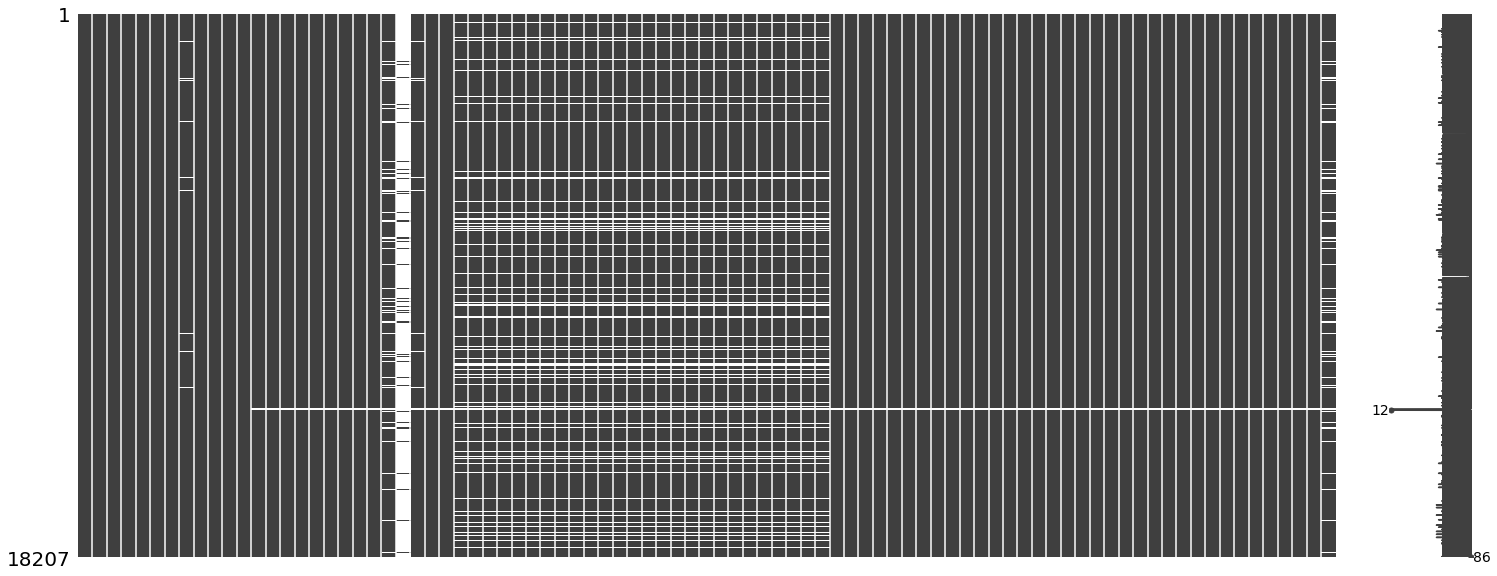

In [21]:
msno.matrix(df)

<AxesSubplot:>

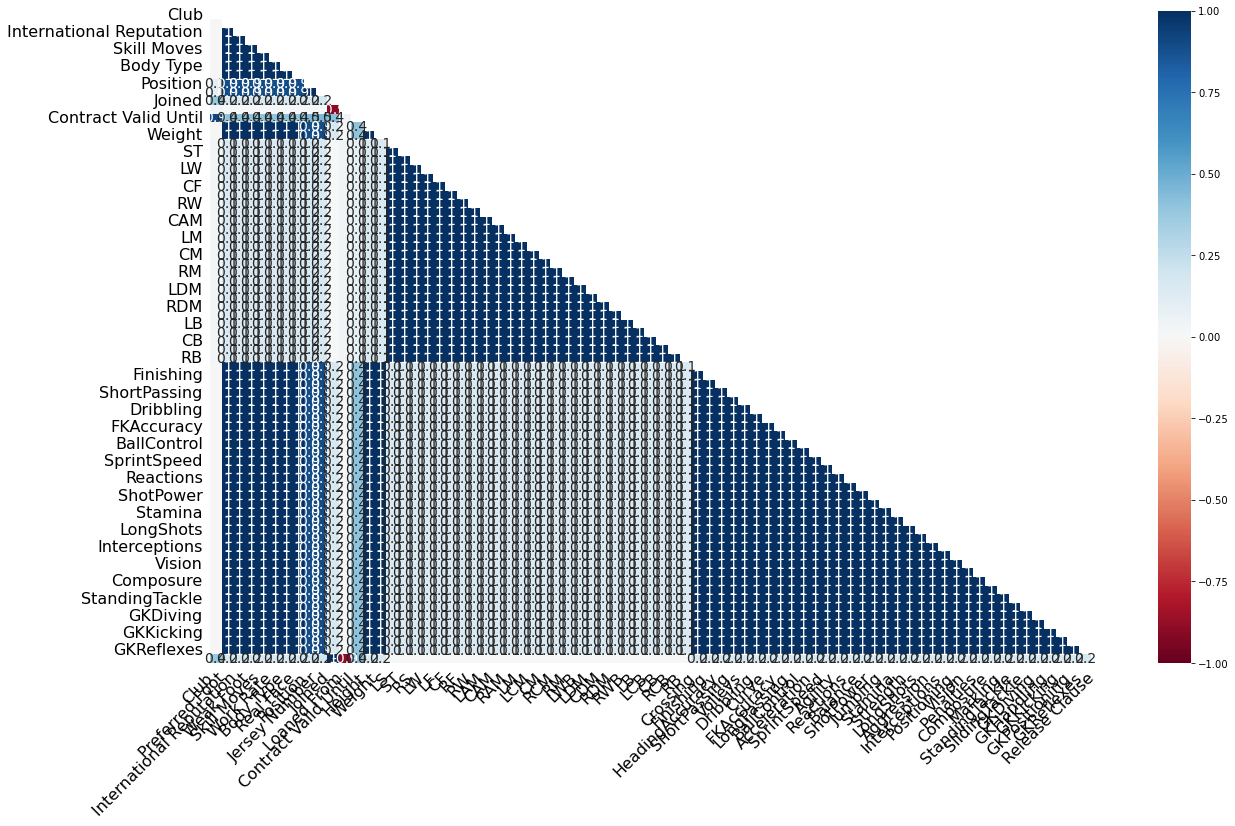

In [22]:
msno.heatmap(df)

## Visualize the Target Variable

In [18]:
df["Position"].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB', nan], dtype=object)

In [19]:
df["Position"].describe()

count     18147
unique       27
top          ST
freq       2152
Name: Position, dtype: object

In [20]:
df["Position"].isnull().sum()

60

In [21]:
df_positions_empty = df[df["RAM"].isna()]
df_positions_empty.head()

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
3,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
9,J. Oblak,25,https://cdn.sofifa.org/players/4/19/200389.png,Slovenia,https://cdn.sofifa.org/flags/44.png,90,93,Atlético Madrid,https://cdn.sofifa.org/teams/2/light/240.png,€68M,...,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M
18,M. ter Stegen,26,https://cdn.sofifa.org/players/4/19/192448.png,Germany,https://cdn.sofifa.org/flags/21.png,89,92,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€58M,...,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,€123.3M
19,T. Courtois,26,https://cdn.sofifa.org/players/4/19/192119.png,Belgium,https://cdn.sofifa.org/flags/7.png,89,90,Real Madrid,https://cdn.sofifa.org/teams/2/light/243.png,€53.5M,...,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,€113.7M
22,M. Neuer,32,https://cdn.sofifa.org/players/4/19/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,89,89,FC Bayern München,https://cdn.sofifa.org/teams/2/light/21.png,€38M,...,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,€62.7M


In [22]:
df_positions_empty["Position"].value_counts()

GK    2025
Name: Position, dtype: int64

<AxesSubplot:title={'center':'Frequency of Each Position in the Dataset'}, xlabel='Position', ylabel='Frequency of Position'>

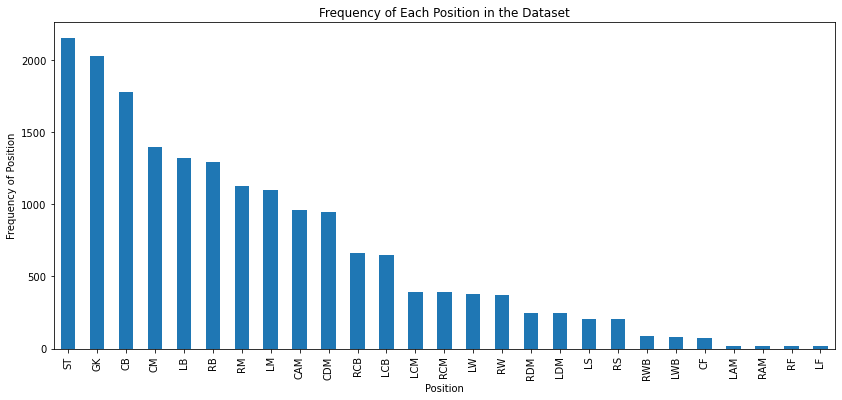

In [23]:
df_position_count = df["Position"].value_counts()
df_position_count.plot(kind = "bar", title = "Frequency of Each Position in the Dataset", xlabel = "Position", ylabel = "Frequency of Position", figsize=[14, 6])

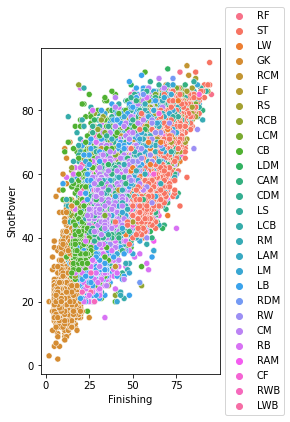

In [24]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.scatterplot(ax=ax, x="Finishing", y="ShotPower", hue="Position", data=df)
        
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## Select columns of interest

In [25]:
df = df[["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Preferred Foot']]
df.dropna(subset=['Position'], inplace=True)
df

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Preferred Foot
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,Left
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,Right
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,Right
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,Right
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,Right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,CM,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,Right
18203,ST,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,Right
18204,ST,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,Right
18205,RW,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,Right


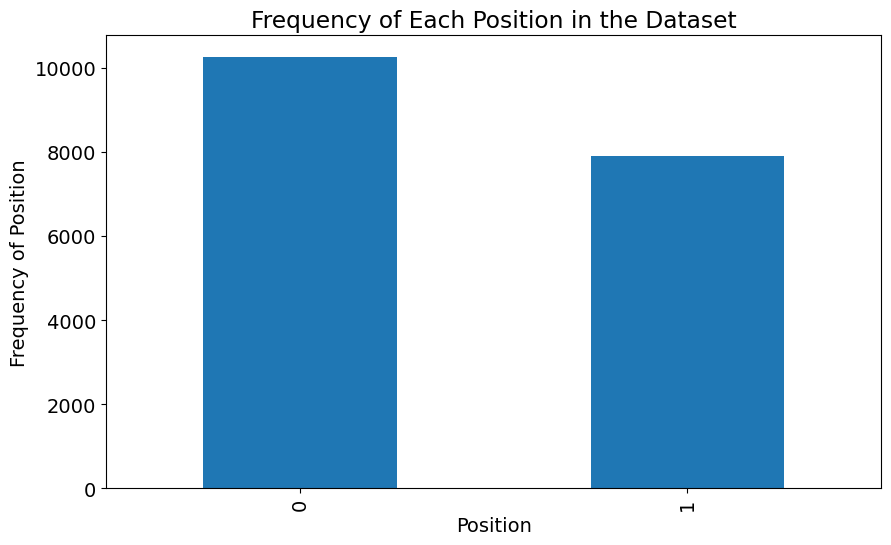

In [119]:
df_position_count = df["Position"].value_counts()
df_position_count.plot(kind = "bar", title = "Frequency of Each Position in the Dataset", xlabel = "Position", ylabel = "Frequency of Position", figsize=[10, 6])
plt.savefig(fname + 'position_bar_plot')

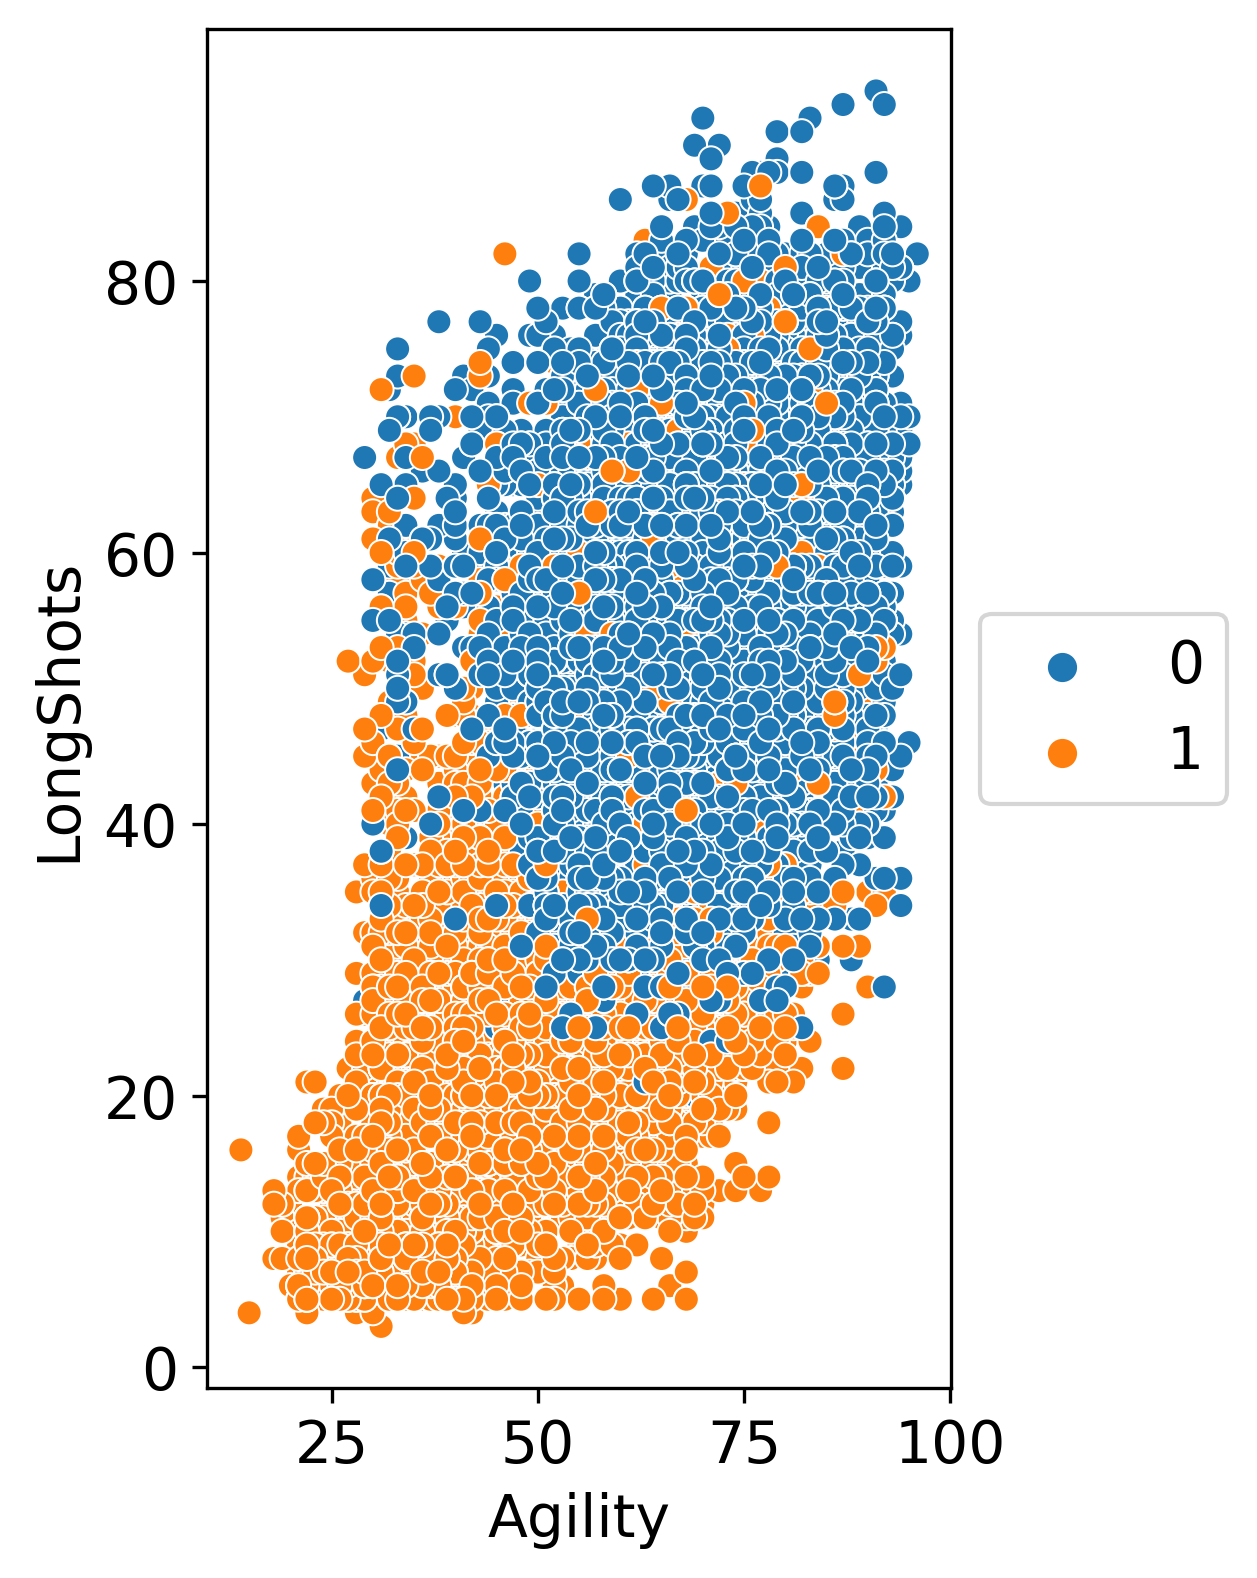

<Figure size 600x400 with 0 Axes>

In [117]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.scatterplot(ax=ax, x="Agility", y="LongShots", hue="Position", data=df)
        
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams["figure.dpi"] = 100
plt.show()
plt.savefig(fname + 'two_category_scatterplot')

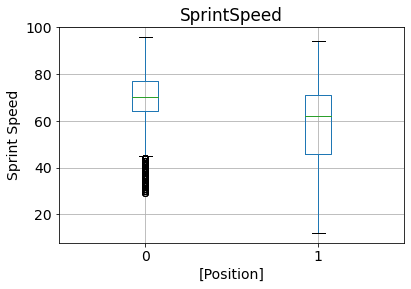

<Figure size 432x288 with 0 Axes>

In [105]:
df[['Position','SprintSpeed']].boxplot(by='Position') 
plt.ylabel('Sprint Speed')
plt.suptitle('')
plt.show()
plt.savefig(fname + 'box_plot')

In [112]:
dataset = [df[df['Position']== 0]['Strength'].values, df[df['Position']== 1]['Strength'].values]

[array([59., 79., 49., ..., 32., 48., 60.]),
 array([64., 83., 78., ..., 59., 38., 52.])]

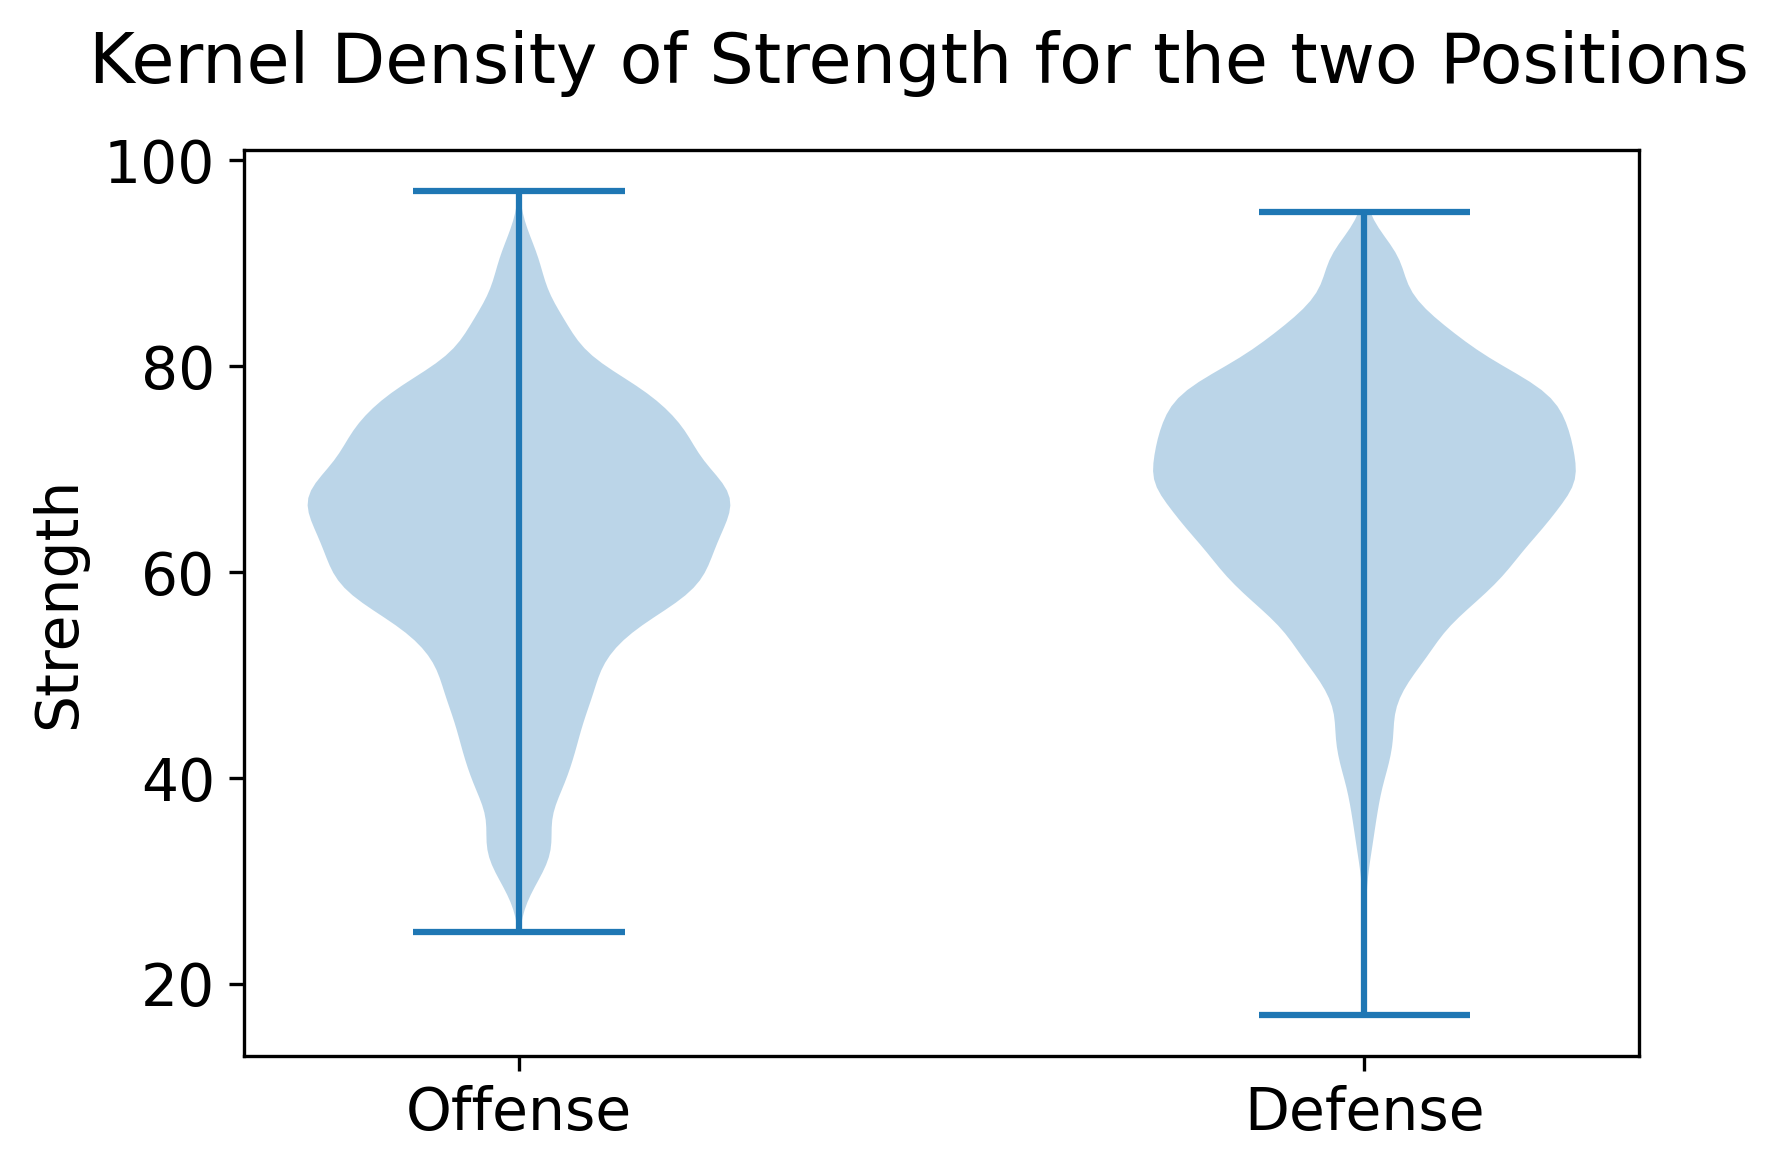

<Figure size 1800x1200 with 0 Axes>

In [217]:
plt.violinplot(dataset = dataset) 
plt.xticks([1, 2],['Offense', 'Defense']) 
plt.ylabel('Strength')
plt.suptitle('Kernel Density of Strength for the two Positions')
plt.show()
plt.savefig(fname + 'violin_plot')

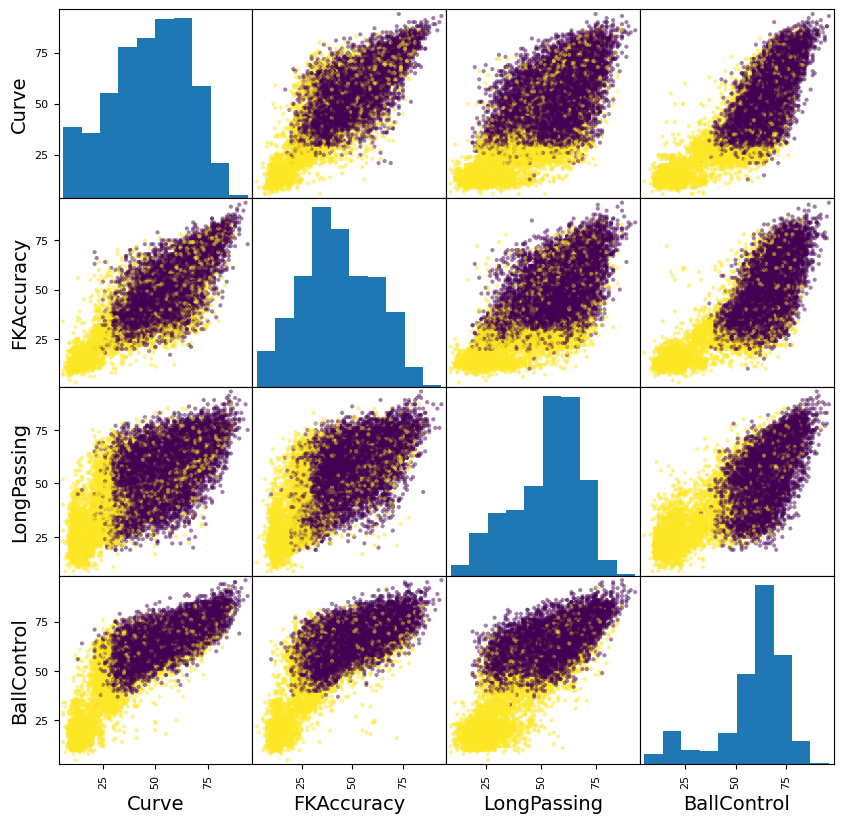

In [216]:
scatter_matrix_cols_df = df[['Curve', 'FKAccuracy', 'LongPassing', 'BallControl']]
scatter_matrix_cols_df

pd.plotting.scatter_matrix(scatter_matrix_cols_df, figsize = (10, 10), c = df["Position"])
plt.rcParams["figure.dpi"] = 300
plt.savefig(fname + 'scatter_matrix_plot.png')

In [28]:
offense = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF", 
           "CM","RCM","LCM", "CAM", "LAM", "RAM", "RM", "LM"]
defense = ["CB", "RCB", "LCB", "LWB", "CDM","RDM","LDM", "RWB", "LB", "RB", "GK"]

In [29]:
#df.loc[df["Position"].isin(defender), "Position"] = 0
df.loc[df["Position"].isin(offense), "Position"] = 0
df.loc[df["Position"].isin(defense), "Position"] = 1
#df.loc[df["Position"].isin(goalkeeper), "Position"] = 3
df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Preferred Foot
0,0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,Left
1,0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,Right
2,0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,Right
3,1,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,Right
4,0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,Right


In [31]:
count_numerical_values = len(df.select_dtypes(include = numerical_values).columns)
count_categorical_values = len(df.select_dtypes(include = categorical_values).columns)

print("Number of Numerical Features: ", count_numerical_values)
print("Number of Categorical Features: ", count_categorical_values)
df.head()

Number of Numerical Features:  33
Number of Categorical Features:  2


,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Preferred Foot
0,0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,Left
1,0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,Right
2,0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,Right
3,1,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,Right
4,0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,Right


In [37]:
df.loc[:, df.isnull().any()].columns

Index([], dtype='object')

In [125]:
X = df.loc[:, df.columns != "Position"]
y = df["Position"]
ftr_names = X.columns
print(X.shape)
print(y.shape)
print(df["Position"].value_counts())

(18147, 34)
(18147,)
0    10256
1     7891
Name: Position, dtype: int64


In [51]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

OneHotEncoder_ftrs = ["Preferred Foot"]

MinMaxScaler_ftrs = ['Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

OneHot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))]) 
                                                                                      
minmax_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers = [ 
        ('minmax', minmax_transformer, MinMaxScaler_ftrs),
        ('onehot', OneHot_transformer, OneHotEncoder_ftrs)
    ])

In [136]:
nr_states = 5
random_state = 42
models = []
output = []

def MLPipe_KFold_AUC_ROC(X, y, preprocessor, ML_algo, param_grid):
    for i in range(5):
        X_other, X_test, Y_other, Y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state * i)
        kf = KFold(n_splits = 4, shuffle = True, random_state = random_state * i)
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("ml_algo", ML_algo)])
        grid = GridSearchCV(pipe, param_grid = param_grid, scoring = "roc_auc", cv=kf, return_train_score = True,
                           n_jobs =- 1, verbose = True)
        grid.fit(X_other, Y_other)
        output = grid.cv_results_
        best_params = grid.best_params_
        score = grid.best_score_
        print("Optimal Model Parameters: ", best_params)
        print("ROC AUC Score: ", score)
        models.append(grid)
        y_pred_test = models[-1].predict(X_test)

In [53]:
ML_algo = RandomForestClassifier()

param_grid = { 
    'ml_algo__n_estimators': [100, 200, 500, 1000],
    'ml_algo__max_features': ['auto', 'sqrt', 'log2'], 
    'ml_algo__criterion': ['gini', 'entropy']
}

MLPipe_KFold_AUC_ROC(X, y, preprocessor, ML_algo, param_grid)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'entropy', 'ml_algo__max_features': 'log2', 'ml_algo__n_estimators': 1000}
ROC AUC Score:  0.9875951898486339
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'entropy', 'ml_algo__max_features': 'log2', 'ml_algo__n_estimators': 1000}
ROC AUC Score:  0.9870888943452735
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'entropy', 'ml_algo__max_features': 'log2', 'ml_algo__n_estimators': 1000}
ROC AUC Score:  0.9873362436575751
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'entropy', 'ml_algo__max_features': 'auto', 'ml_algo__n_estimators': 1000}
ROC AUC Score:  0.9877008190017524
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'entr

## Let's fetch the best parameters from the trained model and print the classification report

In [199]:
score_list = []

def MLPipe_KFold_AUC_ROC_RF(X, y, preprocessor, ML_algo, param_grid):
    X_other, X_test, Y_other, Y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
    kf = KFold(n_splits = 4, shuffle = True, random_state = random_state)
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("ml_algo", ML_algo)])
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = "roc_auc", cv=kf, return_train_score = True,
                        n_jobs =- 1, verbose = 10)
    grid.fit(X_other, Y_other)
    feature_names = MinMaxScaler_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['onehot'][0].get_feature_names(OneHotEncoder_ftrs))
    models.append(grid)
    y_pred_test = models[-1].predict(X_test)
    calc_score = roc_auc_score(y_pred_test, Y_test)
    score_list.append(calc_score)
    output = grid.cv_results_
    print("ROC AUC Score: ", calc_score)
    class_score = classification_report(y_pred_test, Y_test)
    print(class_score)
    
    return grid, np.array(feature_names), X_test, Y_test

In [223]:
ML_algo = RandomForestClassifier()

param_grid = { 
        'ml_algo__n_estimators': [1000],
        'ml_algo__max_features': ['log2'], 
        'ml_algo__criterion': ['entropy']
    }

grid, feature_names, X_test, Y_test = MLPipe_KFold_AUC_ROC_RF(X, y, preprocessor, ML_algo, param_grid)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
ROC AUC Score:  0.9480291977118448
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2056
           1       0.94      0.94      0.94      1574

    accuracy                           0.95      3630
   macro avg       0.95      0.95      0.95      3630
weighted avg       0.95      0.95      0.95      3630



In [224]:
grid

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('minmax',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['Finishing',
                                                                          'HeadingAccuracy',
                                                                          'ShortPassing',
                                                                          'Volleys',
                                                                          'Dribbling',
                                                                          'Curve',
                                                             

[CV 3/4; 1/1] START ml_algo__criterion=entropy, ml_algo__max_features=log2, ml_algo__n_estimators=1000
[CV 3/4; 1/1] END ml_algo__criterion=entropy, ml_algo__max_features=log2, ml_algo__n_estimators=1000;, score=(train=1.000, test=0.986) total time=  18.3s
[CV 1/4; 1/1] START ml_algo__criterion=entropy, ml_algo__max_features=log2, ml_algo__n_estimators=1000
[CV 1/4; 1/1] END ml_algo__criterion=entropy, ml_algo__max_features=log2, ml_algo__n_estimators=1000;, score=(train=1.000, test=0.988) total time=  18.0s
[CV 1/4; 1/1] START ml_algo__criterion=entropy, ml_algo__max_features=log2, ml_algo__n_estimators=1000
[CV 1/4; 1/1] END ml_algo__criterion=entropy, ml_algo__max_features=log2, ml_algo__n_estimators=1000;, score=(train=1.000, test=0.988) total time=  18.2s
[CV 3/4; 1/1] START ml_algo__criterion=entropy, ml_algo__max_features=log2, ml_algo__n_estimators=1000
[CV 3/4; 1/1] END ml_algo__criterion=entropy, ml_algo__max_features=log2, ml_algo__n_estimators=1000;, score=(train=1.000, tes

In [201]:
print(score_list)

[0.948704470966545]


In [56]:
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(np.shape(X_test_transformed))
# calculate shap values on the first 50 points in the test
shap_values = explainer.shap_values(X_test_transformed[:100])
print(np.shape(shap_values))

(3630, 35)
(2, 100, 35)


In [163]:
index = 1 # the index of the point to explain
print(explainer.expected_value[0]) 
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], 
                features = X_test_transformed[index,:],feature_names = feature_names)

0.5640866570228011


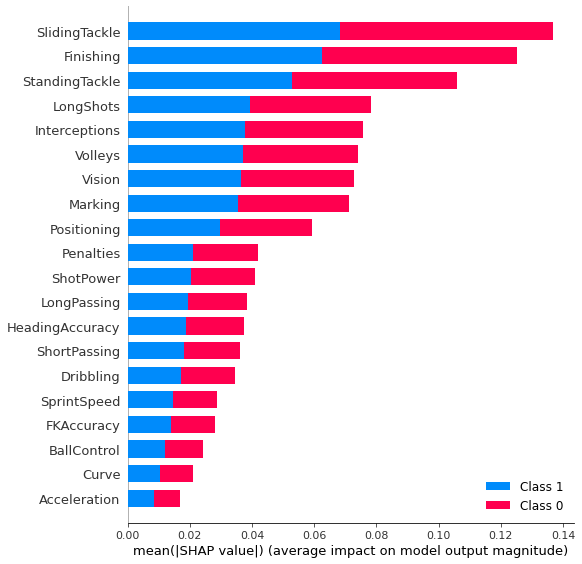

In [62]:
shap.summary_plot(shap_values, X_test_transformed,feature_names = feature_names)

In [66]:
ML_algo = LogisticRegression()

param_grid = { 
    'ml_algo__solver': ['saga', 'newton-cg', 'lbfgs', 'liblinear'],
    'ml_algo__max_iter': [1000], 
    'ml_algo__C': [1e6, 1e5, 1e4, 1e3, 1e2]
}

MLPipe_KFold_AUC_ROC(X, y, preprocessor, ML_algo, param_grid)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Optimal Model Parameters:  {'ml_algo__C': 100.0, 'ml_algo__max_iter': 1000, 'ml_algo__solver': 'liblinear'}
ROC AUC Score:  0.9860891543835328
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Optimal Model Parameters:  {'ml_algo__C': 100.0, 'ml_algo__max_iter': 1000, 'ml_algo__solver': 'saga'}
ROC AUC Score:  0.985550367274955
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Optimal Model Parameters:  {'ml_algo__C': 100.0, 'ml_algo__max_iter': 1000, 'ml_algo__solver': 'saga'}
ROC AUC Score:  0.9859745290194017
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Optimal Model Parameters:  {'ml_algo__C': 100.0, 'ml_algo__max_iter': 1000, 'ml_algo__solver': 'liblinear'}
ROC AUC Score:  0.9862522582589599
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Optimal Model Parameters:  {'ml_algo__C': 100.0, 'ml_algo__max_iter': 1000, 'ml_algo__solver': 'lbfgs'}
ROC AUC Score:  0.986141709676

In [210]:
scores_list_lr = []

def MLPipe_KFold_AUC_ROC_LR(X, y, preprocessor, ML_algo, param_grid):
    X_other, X_test, Y_other, Y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
    kf = KFold(n_splits = 4, shuffle = True, random_state = random_state)
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("ml_algo", ML_algo)])
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = "roc_auc", cv=kf, return_train_score = True,
                        n_jobs =- 1, verbose = 10)
    grid.fit(X_other, Y_other)
    feature_names = MinMaxScaler_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['onehot'][0].get_feature_names(OneHotEncoder_ftrs))
    models.append(grid)
    y_pred_test = models[-1].predict(X_test)
    calc_score = roc_auc_score(y_pred_test, Y_test)
    scores_list_lr.append(calc_score)
    output = grid.cv_results_
    print("ROC AUC Score: ", calc_score)
    class_score = classification_report(y_pred_test, Y_test)
    print(class_score)
    
    return grid, np.array(feature_names), X_test, Y_test

In [211]:
ML_algo = LogisticRegression()

param_grid = { 
        'ml_algo__solver': ['liblinear'],
        'ml_algo__max_iter': [1000], 
        'ml_algo__C': [100]
    }

grid, feature_names, X_test, Y_test = MLPipe_KFold_AUC_ROC_LR(X, y, preprocessor, ML_algo, param_grid)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
ROC AUC Score:  0.9464498194728999
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2069
           1       0.94      0.94      0.94      1561

    accuracy                           0.95      3630
   macro avg       0.95      0.95      0.95      3630
weighted avg       0.95      0.95      0.95      3630



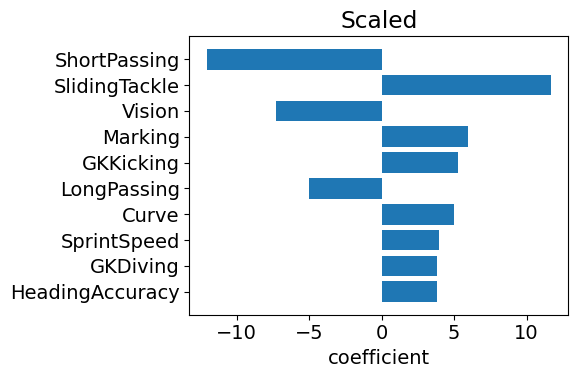

In [213]:
coefficients = grid.best_estimator_[-1].coef_[0]
sort = np.argsort(np.abs(coefficients))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefficients[sort[-10:]])
plt.yticks(np.arange(10),feature_names[sort[-10:]])
plt.xlabel('coefficient')
plt.title('Scaled')
plt.tight_layout()
plt.savefig(fname + 'global_feature_scaled.png')

In [214]:
np.random.seed(42)

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,Y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(Y_test == 0)/len(Y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,Y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.9881540246049175
test baseline =  0.5691460055096419
shuffling Finishing
   shuffled test score: 0.985 +/- 0.0
shuffling HeadingAccuracy
   shuffled test score: 0.985 +/- 0.0
shuffling ShortPassing
   shuffled test score: 0.951 +/- 0.002
shuffling Volleys
   shuffled test score: 0.988 +/- 0.0
shuffling Dribbling
   shuffled test score: 0.988 +/- 0.0
shuffling Curve
   shuffled test score: 0.982 +/- 0.001
shuffling FKAccuracy
   shuffled test score: 0.988 +/- 0.0
shuffling LongPassing
   shuffled test score: 0.983 +/- 0.001
shuffling BallControl
   shuffled test score: 0.986 +/- 0.0
shuffling Acceleration
   shuffled test score: 0.988 +/- 0.0
shuffling SprintSpeed
   shuffled test score: 0.985 +/- 0.0
shuffling Agility
   shuffled test score: 0.988 +/- 0.0
shuffling Reactions
   shuffled test score: 0.988 +/- 0.0
shuffling Balance
   shuffled test score: 0.988 +/- 0.0
shuffling ShotPower
   shuffled test score: 0.987 +/- 0.0
shuffling Jumping
   shuffled test score: 0.98

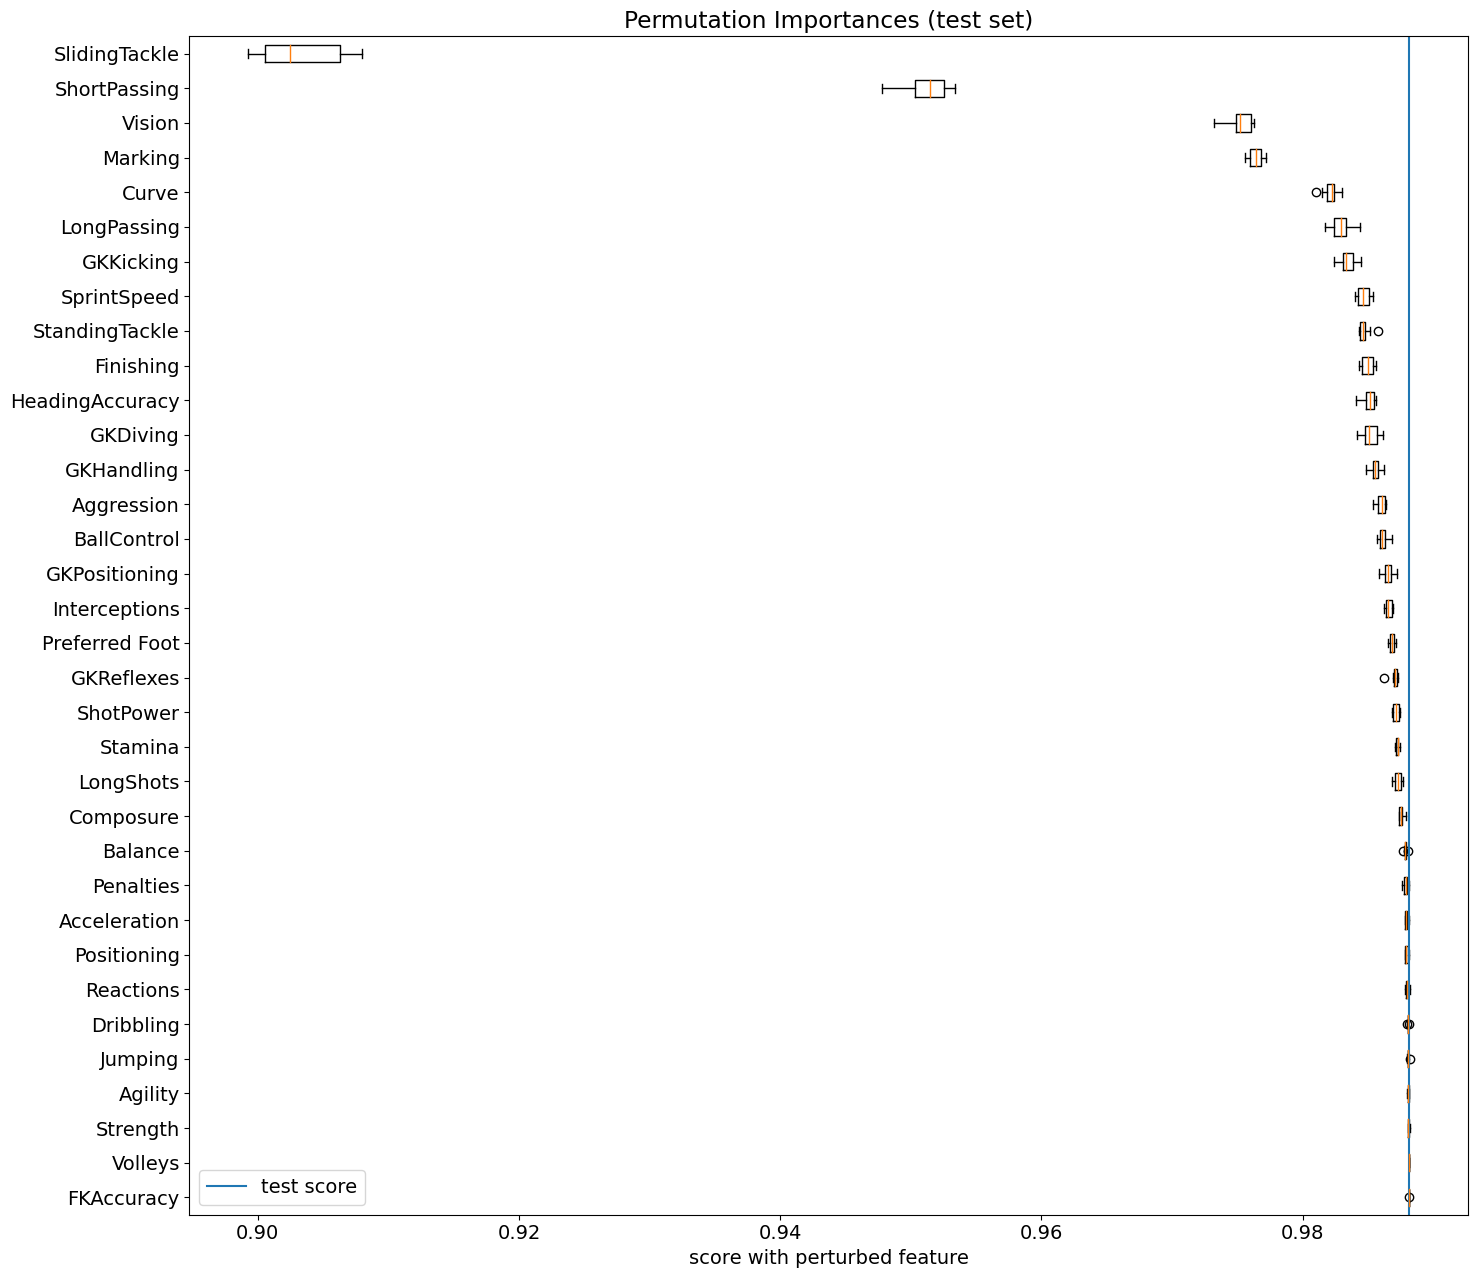

<Figure size 600x400 with 0 Axes>

In [215]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15,13))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(fname + 'permutation_importance_plot.png')

In [84]:
ML_algo = SVC()

param_grid = {
    "ml_algo__kernel":['poly', 'rbf', 'sigmoid'],
    'ml_algo__C':[10, 1, 0.1, 00.1],
    'ml_algo__gamma': [1,0.1,0.01,0.001]
}

MLPipe_KFold_AUC_ROC(X, y, preprocessor, ML_algo, param_grid)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
Optimal Model Parameters:  {'ml_algo__C': 10, 'ml_algo__gamma': 0.1, 'ml_algo__kernel': 'rbf'}
ROC AUC Score:  0.9879915086197065
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Optimal Model Parameters:  {'ml_algo__C': 10, 'ml_algo__gamma': 0.1, 'ml_algo__kernel': 'rbf'}
ROC AUC Score:  0.9874967940733153
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Optimal Model Parameters:  {'ml_algo__C': 10, 'ml_algo__gamma': 0.1, 'ml_algo__kernel': 'rbf'}
ROC AUC Score:  0.9877451831449942
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Optimal Model Parameters:  {'ml_algo__C': 10, 'ml_algo__gamma': 0.1, 'ml_algo__kernel': 'rbf'}
ROC AUC Score:  0.9881588427667902
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Optimal Model Parameters:  {'ml_algo__C': 10, 'ml_algo__gamma': 0.1, 'ml_algo__kernel': 'rbf'}
ROC AUC Score:  0.9880079716244525


In [192]:
scores_list_SVC = []

def MLPipe_KFold_AUC_ROC_SVC(X, y, preprocessor, param_grid, ML_algo):
    X_other, X_test, Y_other, Y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
    kf = KFold(n_splits = 4, shuffle = True, random_state = random_state)
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("ml_algo", ML_algo)])
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = "roc_auc", cv=kf, return_train_score = True,
                        n_jobs =- 1, verbose = 10)
    grid.fit(X_other, Y_other)
    feature_names = MinMaxScaler_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['onehot'][0].get_feature_names(OneHotEncoder_ftrs))
    models.append(grid)
    y_pred_test = models[-1].predict(X_test)
    calc_score = roc_auc_score(y_pred_test, Y_test)
    scores_list_SVC.append(calc_score)
    output = grid.cv_results_
    print("ROC AUC Score: ", calc_score)
    class_score = classification_report(y_pred_test, Y_test)
    print(class_score)
    
    return grid, np.array(feature_names), X_test, Y_test

In [193]:
ML_algo = SVC()

param_grid = {
        "ml_algo__kernel":['rbf'],
        'ml_algo__C':[10],
        'ml_algo__gamma': [0.1]
    }

grid, feature_names, X_test, Y_test = MLPipe_KFold_AUC_ROC_SVC(X, y, preprocessor, param_grid, ML_algo)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
ROC AUC Score:  0.9530041410935246
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2063
           1       0.95      0.95      0.95      1567

    accuracy                           0.95      3630
   macro avg       0.95      0.95      0.95      3630
weighted avg       0.95      0.95      0.95      3630



In [137]:
ML_algo = KNeighborsClassifier()

param_grid = {
    "ml_algo__n_neighbors":[1,10,20,30,50],
    'ml_algo__weights':['uniform', 'distance']}

MLPipe_KFold_AUC_ROC(X,y,preprocessor,ML_algo,param_grid)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Optimal Model Parameters:  {'ml_algo__n_neighbors': 30, 'ml_algo__weights': 'distance'}
ROC AUC Score:  0.9851750391633105
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Optimal Model Parameters:  {'ml_algo__n_neighbors': 30, 'ml_algo__weights': 'distance'}
ROC AUC Score:  0.9842568984847162
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Optimal Model Parameters:  {'ml_algo__n_neighbors': 30, 'ml_algo__weights': 'distance'}
ROC AUC Score:  0.9844579357125197
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Optimal Model Parameters:  {'ml_algo__n_neighbors': 30, 'ml_algo__weights': 'distance'}
ROC AUC Score:  0.9856031977390636
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Optimal Model Parameters:  {'ml_algo__n_neighbors': 50, 'ml_algo__weights': 'distance'}
ROC AUC Score:  0.9848564463755987


In [181]:
scores_list_KNN = []

def MLPipe_KFold_AUC_ROC_KNN(X, y, preprocessor, param_grid, ML_algo):
    X_other, X_test, Y_other, Y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
    kf = KFold(n_splits = 4, shuffle = True, random_state = random_state)
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("ml_algo", ML_algo)])
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = "roc_auc", cv=kf, return_train_score = True,
                        n_jobs =- 1, verbose = 10)
    grid.fit(X_other, Y_other)
    feature_names = MinMaxScaler_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['onehot'][0].get_feature_names(OneHotEncoder_ftrs))
    models.append(grid)
    y_pred_test = models[-1].predict(X_test)
    calc_score = roc_auc_score(y_pred_test, Y_test)
    scores_list_KNN.append(calc_score)
    output = grid.cv_results_
    print("ROC AUC Score: ", calc_score)
    class_score = classification_report(y_pred_test, Y_test)
    print(class_score)
    print(ML_algo)
    
    return grid, np.array(feature_names), X_test, Y_test

In [183]:
ML_algo = KNeighborsClassifier()
param_grid = {
    "ml_algo__n_neighbors":[30],
    'ml_algo__weights':['distance']
    }
grid, feature_names, X_test, Y_test = MLPipe_KFold_AUC_ROC_KNN(X, y, preprocessor, param_grid, ML_algo)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
ROC AUC Score:  0.9376213662377422
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2091
           1       0.92      0.94      0.93      1539

    accuracy                           0.94      3630
   macro avg       0.94      0.94      0.94      3630
weighted avg       0.94      0.94      0.94      3630

KNeighborsClassifier()
[CV 3/4; 1/1] START ml_algo__C=10, ml_algo__gamma=0.1, ml_algo__kernel=rbf......
[CV 3/4; 1/1] END ml_algo__C=10, ml_algo__gamma=0.1, ml_algo__kernel=rbf;, score=(train=0.989, test=0.987) total time=   2.2s
[CV 4/4; 1/1] START ml_algo__C=10, ml_algo__gamma=0.1, ml_algo__kernel=rbf......
[CV 4/4; 1/1] END ml_algo__C=10, ml_algo__gamma=0.1, ml_algo__kernel=rbf;, score=(train=0.988, test=0.988) total time=   2.2s
[CV 1/4; 1/1] START ml_algo__C=10, ml_algo__gamma=0.1, ml_algo__kernel=rbf......
[CV 1/4; 1/1] END ml_algo__C=10, ml_algo__gamma=0.1, ml_algo_

In [162]:


grid, feature_names, X_test, Y_test = MLPipe_KFold_AUC_ROC_KNN(X, y, preprocessor, param_grid, ML_algo):
scores_list_KNN = grid.best_score_
print("KNN Test Score: ", scores_list_KNN)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
ROC AUC Score:  0.9376213662377422
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2091
           1       0.92      0.94      0.93      1539

    accuracy                           0.94      3630
   macro avg       0.94      0.94      0.94      3630
weighted avg       0.94      0.94      0.94      3630

KNeighborsClassifier()
KNN Test Score:  0.9842568984847162
[CV 1/4; 1/1] START ml_algo__n_neighbors=30, ml_algo__weights=distance..........
[CV 1/4; 1/1] END ml_algo__n_neighbors=30, ml_algo__weights=distance;, score=(train=1.000, test=0.985) total time=   1.2s
[CV 4/4; 1/1] START ml_algo__n_neighbors=30, ml_algo__weights=distance..........
[CV 4/4; 1/1] END ml_algo__n_neighbors=30, ml_algo__weights=distance;, score=(train=1.000, test=0.983) total time=   1.3s
[CV 3/4; 1/1] START ml_algo__n_neighbors=30, ml_algo__weights=distance..........
[CV 3/4; 1/1] END ml_algo__n_neig

In [143]:
ML_algo = DecisionTreeClassifier()

param_grid = {
    "ml_algo__criterion":['gini', 'entropy'],
    'ml_algo__max_features':['sqrt', 'log2'], 
    'ml_algo__max_depth': [5, 10, 15]
}

MLPipe_KFold_AUC_ROC(X,y,preprocessor,ML_algo,param_grid)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'entropy', 'ml_algo__max_depth': 5, 'ml_algo__max_features': 'sqrt'}
ROC AUC Score:  0.9554469739485051
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'entropy', 'ml_algo__max_depth': 5, 'ml_algo__max_features': 'sqrt'}
ROC AUC Score:  0.9523895313174978
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'gini', 'ml_algo__max_depth': 5, 'ml_algo__max_features': 'log2'}
ROC AUC Score:  0.9608941623025554
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'gini', 'ml_algo__max_depth': 5, 'ml_algo__max_features': 'log2'}
ROC AUC Score:  0.9578551313847292
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Optimal Model Parameters:  {'ml_algo__criterion': 'gini', 'ml_algo__max_depth': 5, 'm

In [155]:
scores_list_DT = []

def MLPipe_KFold_AUC_ROC_DT(X, y, ML_algo):
    X_other, X_test, Y_other, Y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
    kf = KFold(n_splits = 4, shuffle = True, random_state = random_state)
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("ml_algo", ML_algo)])
    param_grid = {
    "ml_algo__criterion":['gini', 'entropy'],
    'ml_algo__max_features':['sqrt', 'log2'], 
    'ml_algo__max_depth': [5, 10, 15]
    }
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = "roc_auc", cv=kf, return_train_score = True,
                        n_jobs =- 1, verbose = 10)
    grid.fit(X_other, Y_other)
    feature_names = MinMaxScaler_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['onehot'][0].get_feature_names(OneHotEncoder_ftrs))
    models.append(grid)
    y_pred_test = models[-1].predict(X_test)
    calc_score = roc_auc_score(y_pred_test, Y_test)
    scores_list_DT.append(calc_score)
    output = grid.cv_results_
    print("ROC AUC Score: ", calc_score)
    class_score = classification_report(y_pred_test, Y_test)
    print(class_score)
    print(ML_algo)
    
    return grid, np.array(feature_names), X_test, Y_test

In [156]:
grid, feature_names, X_test, Y_test = MLPipe_KFold_AUC_ROC_DT(X, y, ML_algo)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
ROC AUC Score:  0.8578012069829223
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      2141
           1       0.81      0.85      0.83      1489

    accuracy                           0.86      3630
   macro avg       0.85      0.86      0.86      3630
weighted avg       0.86      0.86      0.86      3630

DecisionTreeClassifier()


In [202]:
val = 0.9655499068339428
score_list.append(val)
print(score_list)
print(scores_list_lr)
print(scores_list_KNN)
print(scores_list_SVC)
print(scores_list_DT[0])

[0.948704470966545, 0.9655499068339428]
[0.9464498194728999]
[0.9376213662377422]
[0.9530041410935246]
0.8578012069829223


In [206]:
model_perf = pd.DataFrame({'Model': ['Support Vector Machines', 'Random Forest','Logistic Regression','Decision Tree'],
                         'ROC AUC Score': [scores_list_SVC[0], score_list[1],scores_list_lr[0],scores_list_DT[0]]})

model_perf = model_perf.sort_values(by='ROC AUC Score', ascending=False)

model_perf

,Model,ROC AUC Score
1,Random Forest,0.965550
0,Support Vector Machines,0.953004
2,Logistic Regression,0.946450
3,Decision Tree,0.857801


In [208]:
model_perf.to_csv('results\model_performance.csv')